This project's goal is to show the eigen specturm of free lattice fermion(no gauge boson involved).

Naive ,  Wilson and GW fermions are implemented.

We only use the eigensolver from np.

For real LatticeQCD researching, please to read the Arnoldi algorithm.

In [33]:
# Basic math libraries are imported.

import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
from scipy.linalg import sqrtm

import sys

np.set_printoptions(threshold=sys.maxsize)

# Libraries about the multithreading 
from concurrent.futures import ThreadPoolExecutor, as_completed, ProcessPoolExecutor
from threading import Thread

The gamma matrices in Euclidean space are defined as 4 by 4 array. Shorted hand notation is Gi

In [3]:
G1 = np.array([ [0,0,0,-1.j], [0,0,-1.j,0] , [0,1.j,0,0] , [1.j,0,0,0] ])
G2 = np.array([ [0,0,0,-1] , [0,0,1,0] , [0,1,0,0] , [-1,0,0,0] ])
G3 = np.array([ [0,0,-1.j,0] , [0,0,0,1.j] , [1.j,0,0,0] , [0,-1.j,0,0] ])
G4 = np.array([ [0,0,1,0] , [0,0,0,1] , [1,0,0,0] , [0,1,0,0] ])
G5 = np.array([ [1,0,0,0] , [0,1,0,0] , [0,0,-1,0] , [0,0,0,-1] ])
I = np.array([ [1,0,0,0] , [0,1,0,0] , [0,0,1,0] , [0,0,0,1] ])

Distance is defined as edge term plus inner/a

In [4]:
#Define the integral boundary
def Distance(a, x, y):
    arange = [p for p in np.arange(x / a, y / a)] + [ 0 ] + [y / a]
    return arange

Look-up tables of trigonometric functions are defined.

To accelate the code for multidimension calculation.

Extending to any-ratio of angle is possible but I'm to lazy.

In [34]:
def Distance(a, x, y):
    '''
    
    Generates values from x to y with a step size influenced by 'a' .
    Adjust the step size as needed.
    
    '''
    return np.arange(x, y + a, a * np.pi / 60)  

class SinValue():
    def __init__(self, a):
        self.sin_val = {p: np.sin(p * a) for p in Distance(a, -np.pi, np.pi)}
    
    def get(self, p):
        return self.sin_val.get(p, np.sin(p * a))  # Fallback to compute if not in dict

class SinValueLookup():
    def __init__(self):
        self.lookup = dict()

    def get(self, a, p):
        if a not in self.lookup:
            self.lookup[a] = SinValue(a)
        return self.lookup[a].get(p)

sin_lookup = SinValueLookup()

class CosValue():
    def __init__(self, a):
        self.cos_val = {p: np.cos(p * a) for p in Distance(a, -np.pi, np.pi)}
    
    def get(self, p):
        return self.cos_val.get(p, np.cos(p * a))  # Fallback to compute if not in dict

class CosValueLookup():
    def __init__(self):
        self.lookup = dict()

    def get(self, a, p):
        if a not in self.lookup:
            self.lookup[a] = CosValue(a)
        return self.lookup[a].get(p)

cos_lookup = CosValueLookup()

class SinValueHalf():
    def __init__(self, a):
        self.sin_val = {p: np.sin(p * a * 0.5) for p in Distance(a, -np.pi, np.pi)}
    
    def get(self, p):
        return self.sin_val.get(p, np.sin(p * a * 0.5))  # Fallback to compute if not in dict

class SinValueLookupHalf():
    def __init__(self):
        self.lookup = dict()

    def get(self, a, p):
        if a not in self.lookup:
            self.lookup[a] = SinValueHalf(a)
        return self.lookup[a].get(p)

sin_lookupHalf = SinValueLookupHalf()

In [35]:
class LatticeFermion:
    """
    Base class for Lattice Fermion calculations.
    """

    def __init__(self, m , a):
        self.a = a  # Lattice spacing
        self.m = m  # m = mass

    def compute_eigenvalues(self, *args, **kwargs):
        raise NotImplementedError("This method should be implemented by subclasses.")

    def plot_eigenvalues(self, momenta_range):
        """
        Plot the eigenvalues for a range of momenta.
        """
        eigenvalues = []

        for p1 in momenta_range:
            for p2 in momenta_range:
                for p3 in momenta_range:
                    for p4 in momenta_range:
                        vals, _ = self.compute_eigenvalues(p1, p2, p3, p4)
                        eigenvalues.extend(vals)

        # Extracting real and imaginary parts
        real_parts = [val.real for val in eigenvalues]
        imag_parts = [val.imag for val in eigenvalues]

        # Plotting
        plt.scatter(real_parts, imag_parts, s=1)
        plt.xlabel('Real Part')
        plt.ylabel('Imaginary Part')
        plt.title('Eigenvalues')
        plt.grid(True)
        plt.show()

class NaiveFermion(LatticeFermion):
    def __init__(self, m, a):
        super().__init__(m, a)

    def compute_eigenvalues(self, p1, p2, p3, p4):
        ''' Implement the defintion for Naive Fermion '''
        
        naive_fermion_matrix = self.get_naive_fermion(self.a, p1, p2, p3, p4)
        
        return np.linalg.eig(naive_fermion_matrix)

    def get_naive_fermion(self, p1, p2, p3, p4):
        
        fermion_value = (1.j / self.a) * (G1 * sin_lookup.get(self.a, p1) +
                                          G2 * sin_lookup.get(self.a, p2) +
                                          G3 * sin_lookup.get(self.a, p3) +
                                          G4 * sin_lookup.get(self.a, p4))
        return fermion_value

class WilsonFermion(NaiveFermion):
    def __init__(self, m, a):
        super().__init__(m, a)

    def get_wilson_fermion(self, p1, p2, p3, p4):
        # Use self.a directly within the method
        wilson_term = I * self.a**-1 * (4 - cos_lookup.get(self.a, p1) - 
                                        cos_lookup.get(self.a, p2) - 
                                        cos_lookup.get(self.a, p3) - 
                                        cos_lookup.get(self.a, p4))
        return self.get_naive_fermion(p1, p2, p3, p4) + wilson_term

    def compute_eigenvalues(self, p1, p2, p3, p4):
        # Correctly call get_wilson_fermion without self.a
        wilson_fermion_matrix = self.get_wilson_fermion(p1, p2, p3, p4)
        return np.linalg.eig(wilson_fermion_matrix)
        
class GWfermion(WilsonFermion):
    def __init__(self, m, a):
        super().__init__(m, a)

    def phat(self, p):
        """
        Calculate phat for a given momentum.

        Parameters:
        p - Momentum

        Returns:
        Calculated phat value.
        """
        return (2 / self.a) * sin_lookupHalf.get(self.a, p)

    def pmaru(self, p):
        """
        Calculate pmaru for a given momentum.

        Parameters:
        p - Momentum

        Returns:
        Calculated pmaru value.
        """
        return (1 / self.a) * sin_lookup.get(self.a, p)

    def compute_GW_fermion(self, p1, p2, p3, p4):
        """
        Define the Ginsparg-Wilson Fermion matrix.

        Parameters:
        p1, p2, p3, p4 - Momenta in different directions.

        Returns:
        Ginsparg-Wilson Fermion matrix.
        """
        a = self.a
        ni = 0.5 * a**4  # Overall scaling factor
        phat_squared_terms = [self.phat(p)**2 for p in [p1, p2, p3, p4]]

        # Calculate the ASA, HI, NA, A, and KA components
        ASA = -I * 0.5 * a**2 * sum(phat_squared_terms)
        HI = -a * 1j * sum(G * self.pmaru(p) for G, p in zip([G1, G2, G3, G4], [p1, p2, p3, p4]))
        NA = ni * sum(phat_squared_terms[i]**2 * phat_squared_terms[j]**2 for i in range(3) for j in range(i+1, 4))
        
        # Compute the Ginsparg-Wilson Fermion matrix
        root_term = np.sqrt(1 + NA)
        
        return 1 / a * (I - ((I + ASA + HI) * root_term**(-1)))

    def compute_eigenvalues(self, p1, p2, p3, p4):
        """
        Compute the eigenvalues of the GW Fermion matrix.

        Parameters:
        p1, p2, p3, p4 - Momenta in different directions

        Returns:
        Eigenvalues of the GW Fermion matrix.
        """
        gw_fermion_matrix = self.compute_GW_fermion(p1, p2, p3, p4)
        return np.linalg.eig(gw_fermion_matrix)

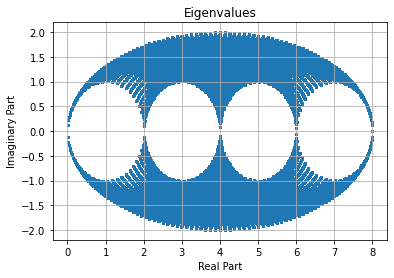

In [36]:
# Example usage:
a = 1
m = 0  
momenta_range = np.linspace(-np.pi, np.pi, 50)  # Adjust as needed

# For GW fermion
gw_fermion = WilsonFermion(m, a)
gw_fermion.plot_eigenvalues(momenta_range)